In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use('default')

import seaborn as sns
from tqdm import tqdm
import tensorflow as tf

%matplotlib inline

import sys

In [3]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, max_error, r2_score
import pandas as pd


def erapm(real_data, predicted_data):
    """This function will calculate the average relative percentage error.

    Args:
        real_data (_type_): _description_
        predicted_data (_type_): _description_
    """

    absolute_errors = abs(real_data - predicted_data)
    relative_errors = (absolute_errors / real_data) * 100
    max_relative_error = np.round(relative_errors.max().max(),4)
    print(f"Erro Relativo Percentual Médio: {max_relative_error}")

    return max_relative_error
    

def erpm(real_data, predicted_data):
    """This function will calculate the absolute max percentage error.

    Args:
        real_data (_type_): _description_
        predicted_data (_type_): _description_
    """
    # Erro relativo percentual maximo
    
    absolute_percentage_errors = abs((real_data - predicted_data) / real_data) * 100
    max_relative_error = np.round(absolute_percentage_errors.max().max(),4)
    
    return max_relative_error


def erp_std(real_data, predicted_data):
    """This function will calculate the absolute max percentage error.

    Args:
        real_data (_type_): _description_
        predicted_data (_type_): _description_
    """
    # Erro relativo percentual maximo
    
    absolute_percentage_errors = abs((real_data - predicted_data) / real_data) * 100
    std = np.std(absolute_percentage_errors)
    
    return std


def get_metrics(real_data, predicted_data):

    print(f"MAE: {np.round(mean_absolute_error(real_data,predicted_data), 4)}")
    print(f"MSE: {np.round(mean_squared_error(real_data,predicted_data), 4)}")
    print(f"RMSE: {np.round(np.sqrt(mean_squared_error(real_data,predicted_data)), 4)}")
    print(f"MAPE: {np.round(mean_absolute_percentage_error(real_data,predicted_data)*100, 4)}")
    print(f"ERPM: {np.round(erpm(real_data,predicted_data), 4)}")
    # return np.round(mean_absolute_percentage_error(real_data,predicted_data)*100, 4)


#====================================================================================================================

def gera_metricas(df,nome_real,nome_previsto, verbose=False):
    """
        Recebe um dataframe contendo uma coluna com os valores reais (nome_real) e uma coluna com os valores preditos
        (nome_previsto) e os nomes dessas colunas.
        
        Retorna um dicionário contendo as métricas calculadas e um dataframe contendo os pontos nas duas curvas cujo
        erro absoluto é máximo.
        
        Métricas calculadas:
        RMSE: Raíz quadrada do erro médio quadrático. 
        MSE: Erro médio quadrático.
        MAE: Erro médio absoluto.
        MAXE: Máximo erro absoluto.
        MAXPE: Erro máximo percentual absoluto - Valor percentual do máximo erro absoluto.
        Dessa forma, o ponto utilizado para calcular essa métrica é o mesmo ponto do valor máximo absoluto.
        MAPE: Erro médio percentual. Desconsidera valores abaixo de 1 do valor real da variável de saída. Isso evita que
        o valor dessa métrica tenda a infinito por conta de pontos onde a variável de saída tende a zero.
        R2: Coeficiente de determinação.
    """

    df_out = df.copy()
    df_out['dif_abs'] = abs(df_out[nome_real]-df_out[nome_previsto])
    

    # MSE: Erro médio quadrático.
    mse = mean_squared_error(df_out[nome_real], df_out[nome_previsto])

    # RMSE: Raíz quadrada do erro médio quadrático.
    rmse = np.sqrt(mse)

    # MAE: Erro médio absoluto
    mae = mean_absolute_error(df_out[nome_real], df_out[nome_previsto])
    
    # MAXE: Máximo erro absoluto.
    maxe = max_error(df_out[nome_real], df_out[nome_previsto])

    # R2: Coeficiente de determinação.
    r2 = r2_score(df_out[nome_real], df_out[nome_previsto])
    
    # MAPE: Erro médio percentual.
    df_out = df[df[nome_real]>=1]
    mape = mean_absolute_percentage_error(df_out[nome_real], df_out[nome_previsto])*100

    # MAXPE: Erro máximo percentual absoluto - Valor percentual do máximo erro absoluto.  
    maxdif = pd.DataFrame()
    maxdif[nome_previsto] = df_out[df_out['dif_abs']==df_out['dif_abs'].max()][nome_previsto]
    maxdif[nome_real] = df_out[df_out['dif_abs']==df_out['dif_abs'].max()][nome_real]
    
    m1 = maxdif[nome_previsto].values
    m2 = maxdif[nome_real].values
    max_pe = (m1[0]-m2[0])/m2[0]
    max_pe = abs(max_pe)*100

    metricas = {"RMSE":rmse,
                "MSE":mse,
                "MAE":mae,
                "MAXE":maxe,
                "MAXPE":max_pe,
                "MAPE":mape,
                "R2":r2 }

    if verbose==True:
        for k in metricas.keys():
            print(f'{k}: {metricas[k]: .3f}')
        
    return metricas, maxdif

#====================================================================================================================

In [4]:
df = pd.read_parquet('./data/1s/train_data.parquet')
new_order = ['Frequencia CMB', 'CV-1', 'PT-2(K-1)', 'PT-2(K-2)', 'PT-2']
df = df.reindex(columns=new_order)
df.head()

,Frequencia CMB,CV-1,PT-2(K-1),PT-2(K-2),PT-2
0,40.0,0.566076,6.786421,6.776293,6.784635
1,40.0,0.563997,6.784635,6.786421,6.784970
2,40.0,0.567120,6.784970,6.784635,6.779464
3,40.0,0.566799,6.779464,6.784970,6.779018
4,40.0,0.568892,6.779018,6.779464,6.771205


In [5]:
#Normalizando
data = tf.keras.utils.normalize(np.array(df), axis=0)
nor = np.linalg.norm(df, axis=0, keepdims=True)

In [6]:
from sklearn.model_selection import train_test_split

# Separando os dados em X e y
X = data[:, 0:4]
y = data[:, 4:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)

In [7]:
from sklearn.feature_selection import SelectKBest, f_regression

# Verificando a importancia de cada parametro

selector = SelectKBest(score_func=f_regression, k='all')
fit = selector.fit(X_train, y_train)

scores = fit.scores_

df_scores = pd.DataFrame({'Feature': df.columns[:4], 'Score': scores}).sort_values(by='Score', ascending=False)
df_scores

C:\Users\ra-no\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Feature,Score
2,PT-2(K-1),1.119182e+07
3,PT-2(K-2),2.489906e+06
0,Frequencia CMB,3.452587e+03
1,CV-1,1.942003e+03


In [8]:
# Adicionei um early stopping se o erro não cair por 250 épocas, para minimizar a hipótese de overfitting
from tensorflow.keras.callbacks import EarlyStopping


model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(4))
model.add(tf.keras.layers.Dense(45,activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(45,activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(1,activation='linear'))


model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics = ['mean_squared_error'])

early_stop = EarlyStopping(monitor='mean_squared_error', patience=250)

model.fit(X_train, y_train, epochs=5000, callbacks=[early_stop])

Epoch 1/5000
88/88 [==============================] - 1s 2ms/step - loss: 1.0518e-05 - mean_squared_error: 1.0518e-05
Epoch 2/5000
88/88 [==============================] - 0s 2ms/step - loss: 9.6449e-08 - mean_squared_error: 9.6449e-08
Epoch 3/5000
88/88 [==============================] - 0s 2ms/step - loss: 6.8085e-08 - mean_squared_error: 6.8085e-08
Epoch 4/5000
88/88 [==============================] - 0s 2ms/step - loss: 6.7112e-08 - mean_squared_error: 6.7112e-08
Epoch 5/5000
88/88 [==============================] - 0s 2ms/step - loss: 5.8459e-08 - mean_squared_error: 5.8459e-08
Epoch 6/5000
88/88 [==============================] - 0s 2ms/step - loss: 6.6045e-08 - mean_squared_error: 6.6045e-08
Epoch 7/5000
88/88 [==============================] - 0s 2ms/step - loss: 6.1197e-08 - mean_squared_error: 6.1197e-08
Epoch 8/5000
88/88 [==============================] - 0s 4ms/step - loss: 7.5139e-08 - mean_squared_error: 7.5139e-08
Epoch 9/5000
88/88 [==============================] - 0s

In [9]:
y_predict = model.predict(X_test)

10/10 [==============================] - 0s 1ms/step


In [10]:
get_metrics(y_test, y_predict)

MAE: 0.0001
MSE: 0.0
RMSE: 0.0002
MAPE: 0.6573
ERPM: 51.8864


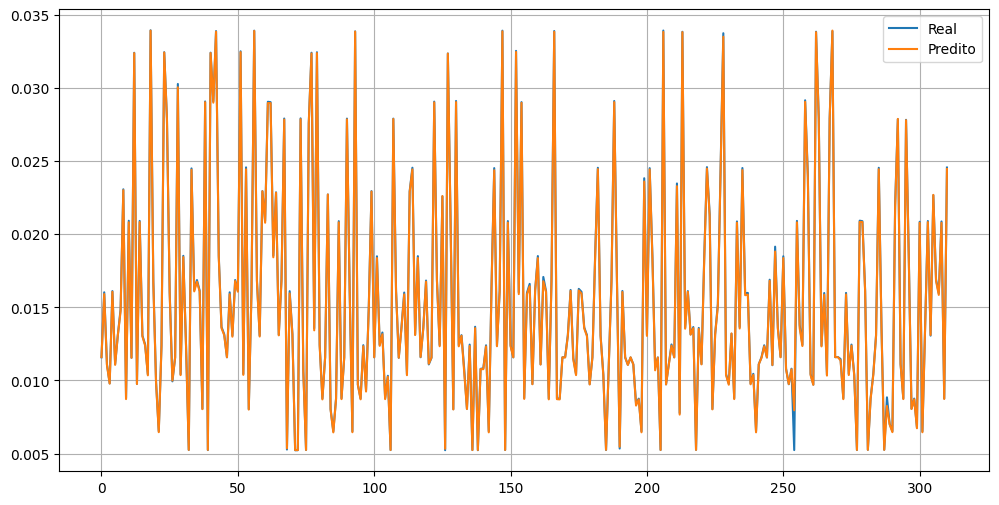

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Real')
plt.plot(y_predict, label='Predito')
plt.legend()
plt.grid()
plt.show()

In [12]:
y_p_ = model.predict(X)

98/98 [==============================] - 0s 1ms/step


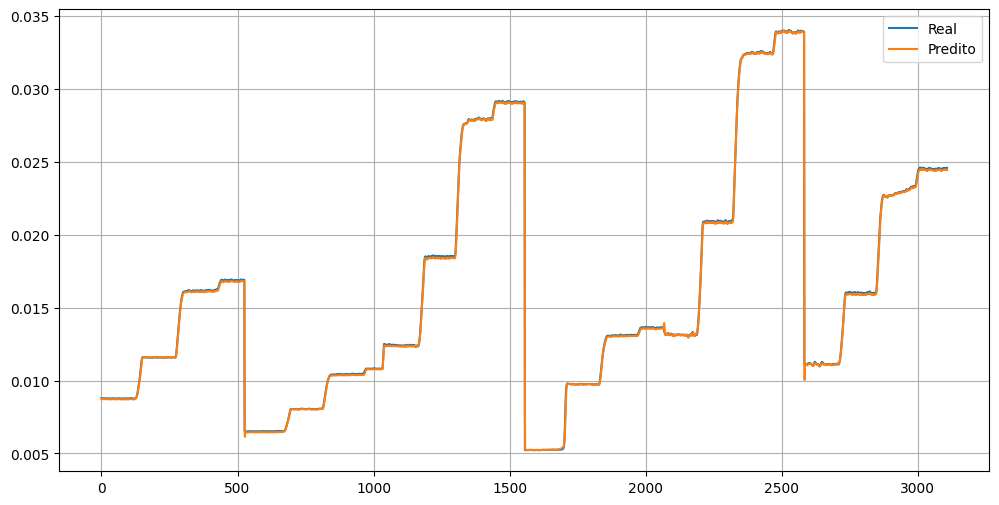

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(y, label='Real')
plt.plot(y_p_, label='Predito')
plt.legend()
plt.grid()
plt.show()

In [14]:
model.save('modelo_RNA.h5')

97/97 [==============================] - 0s 1ms/step


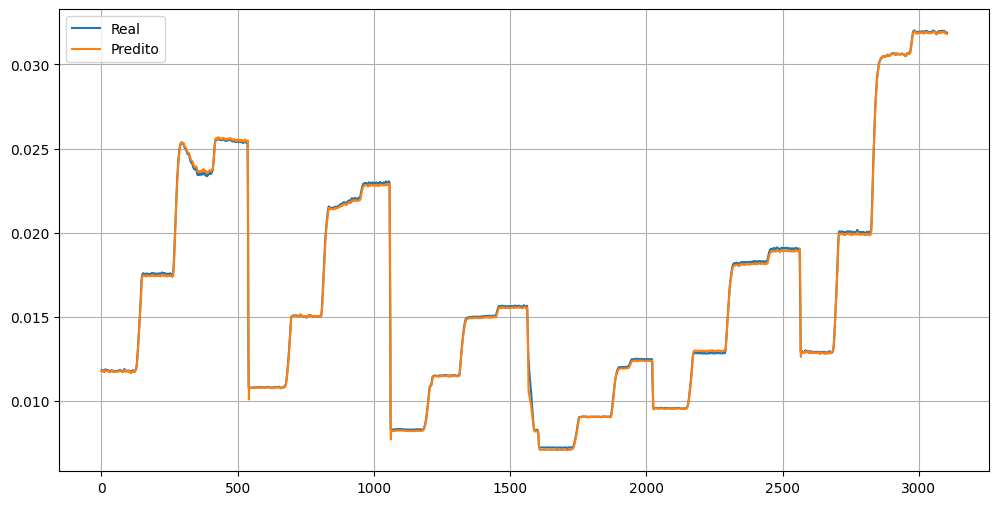

In [15]:
# Carregando os dados de teste
df = pd.read_parquet('./data/1s/test_data.parquet')

# Reordenando as colunas
new_order = ['Frequencia CMB', 'CV-1', 'PT-2(K-1)', 'PT-2(K-2)', 'PT-2']
df = df.reindex(columns=new_order)

# Normalizando os dados usando a mesma escala dos valores de treino (supondo que 'nor' esteja definido)
df_normalized = df.div(nor)

# Separando os dados de entrada (X) e de saída (y)
X = df_normalized.iloc[:, :4].values
y_true = df_normalized.iloc[:, 4:].values

# Fazendo a previsão usando o modelo
y_pred = model.predict(X)

# Plotando os resultados
plt.figure(figsize=(12, 6))
plt.plot(y_true, label='Real')
plt.plot(y_pred, label='Predito')
plt.legend()
plt.grid()
plt.show()

In [16]:
get_metrics(y_true * nor[0][4], y_pred* nor[0][4])

MAE: 0.0763
MSE: 0.0177
RMSE: 0.1329
MAPE: 0.681
ERPM: 14.9201
